# Measure variant fitness effect by combining DESeq2 measurements in weighted least squares (WLS) regression

DESeq2 logFC estimates from individual barcodes are fitted into a weighted linear regression to measure variant fitness effects and identify significant GxG interactions.

In [1]:
import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.formula.api import wls
from statsmodels.stats.multitest import multipletests

In [2]:
working_dir="/home/users/rang/scratch/yeast/crispey3/gxg_bya_aug2021/"
os.chdir(working_dir)

## Load files

In [3]:
# counts
counts_file = "./counts/barcode_counts.txt"

# samples file
samples_file = "gxg_bya_aug2021_samples.txt"

# deseq results
deseq_results_file = "./deseq/gxg_bya_aug2021_umi_results.txt"

# neutral barcodes
neutral_barcodes_file = "/home/users/rang/crispey3/library_design/Output/crispey3_neutral_oligos_only.txt"

# oligo design table
oligo_design_file = "/home/users/rang/crispey3/library_design/Output/oligos_nonuniq_crispey3_GG_9bp_OLIGO.txt"


# output paths
var_fitness_file = "gxg_bya_aug2021_varFitness.txt"
gxg_interactions_file = "gxg_bya_aug2021_gxgInteractions.txt"

In [4]:
# load oligo design table
oligo_design_df = pd.read_csv(oligo_design_file, sep='\t', header=0, index_col='barcode_id')
# subset to oligo and variant info only
annotations_df = oligo_design_df[['var_id', 'guide_id', 'oligo_id']]

# load samples info
samples_df = pd.read_csv(samples_file, sep='\t', header=0, index_col=0)

# load neutral barcodes info
neutral_barcodes_df = pd.read_csv(neutral_barcodes_file, sep='\t', header=0, index_col='barcode_id')

# load counts
counts_df = pd.read_csv(counts_file, sep='\t', header=0, index_col=0)
counts_df = counts_df[samples_df.index]
display(counts_df)

# load DESeq2 results
deseq_results_df = pd.read_csv(deseq_results_file, sep='\t', header=0, index_col=0)
deseq_results_df.index.name = 'barcode'
# split barcode name to identify the oligo 
deseq_results_df['barcode_id'] = [x.split('-')[0] for x in deseq_results_df.index]
display(deseq_results_df)

/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (24,25,26,27,28,29,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,BYA-t1-1,BYA-t1-2,BYA-t1-3,BYA-t4-1,BYA-t4-2,BYA-t4-3,BYA-t7-1,BYA-t7-2,BYA-t7-3,BYA-t10-1,BYA-t10-2,BYA-t10-3,BYA-t13-1,BYA-t13-2,BYA-t13-3
barcode,,,,,,,,,,,,,,,
001_022-6,5,4,5,13,4,13,10,17,20,34,20,21,37,18,28
001_045-6,7,6,2,2,2,1,2,6,0,0,0,0,0,0,0
001_119-6,7,0,2,2,2,4,0,0,2,0,0,0,0,0,0
002_017-2,1,10,5,2,11,6,0,6,3,0,1,2,0,0,0
002_019-6,2,3,2,0,0,5,0,0,5,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ladder_042-3,0,1,2,0,0,1,0,0,0,0,0,0,0,0,0
Ladder_043-1,19,9,11,20,1,13,5,14,12,3,11,3,0,7,2
Ladder_043-2,8,10,11,4,12,9,5,13,0,0,2,1,0,3,0


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,barcode_id
barcode,,,,,,,
047_121-4,3548.483213,-2.475391e-02,0.000565,-43.805156,0.000000e+00,0.000000e+00,047_121
047_121-6,3205.760575,-3.126610e-02,0.000848,-36.887936,7.214174e-298,7.580654e-294,047_121
061_121-3,2756.620093,-2.843108e-02,0.000788,-36.071766,6.287350e-285,4.404498e-281,061_121
047_121-3,3347.654107,-3.538647e-02,0.001068,-33.141229,7.575994e-241,3.980427e-237,047_121
073_121-4,2586.163296,-2.838859e-02,0.000859,-33.045208,1.822795e-239,7.661574e-236,073_121
...,...,...,...,...,...,...,...
048_045-6,122.825606,8.072204e-06,0.004648,0.001737,9.986142e-01,9.987687e-01,048_045
043_062-6,3934.939408,-9.284950e-07,0.000539,-0.001722,9.986262e-01,9.987687e-01,043_062
073_030-6,162.889328,6.473160e-06,0.004073,0.001589,9.987319e-01,9.988270e-01,073_030


## Subset counts and deseq results to variants of interest only
The competition libraries contain various amounts of oligos not specific to each project, or are included for technical purposes. They can be filtered out to speed up analyses and/or reduce multiple testing burden

In [5]:
keep = annotations_df.query('var_id.str.contains("GXG") | barcode_id.isin(@neutral_barcodes_df.index)').index

# subset DESeq2 table
deseq_results_df = deseq_results_df.query('barcode_id.isin(@keep)')
# # read depth filters
# deseq_results_df = deseq_results_df.query('baseMean>=66')

# subset counts matrix
counts_df = counts_df.query('barcode.isin(@deseq_results_df.index)')

## Add oligo, variant annotations to DESeq2 results table
Barcodes not in annotations_df (e.g. mismapped barcode sequences) will be removed

In [6]:
deseq_results_df = deseq_results_df.merge(annotations_df[['guide_id', 'oligo_id', 'var_id']], how='inner', left_on='barcode_id', right_index=True)
display(deseq_results_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,barcode_id,guide_id,oligo_id,var_id
barcode,,,,,,,,,,
044_078-5,1356.288997,0.064641,0.002000,32.318893,3.796826e-229,1.329902e-225,044_078,guide_7154,gxg#guide_7154#guide_7154:REF2ALT:offset14:don...,GXG_32727
044_078-1,364.939165,0.021136,0.002693,7.847100,4.257678e-15,5.113107e-14,044_078,guide_7154,gxg#guide_7154#guide_7154:REF2ALT:offset14:don...,GXG_32727
044_078-4,527.386090,0.010527,0.001512,6.962268,3.348375e-12,2.791331e-11,044_078,guide_7154,gxg#guide_7154#guide_7154:REF2ALT:offset14:don...,GXG_32727
044_078-6,285.939291,-0.017400,0.002598,-6.696251,2.138345e-11,1.599838e-10,044_078,guide_7154,gxg#guide_7154#guide_7154:REF2ALT:offset14:don...,GXG_32727
044_078-3,407.980523,0.006086,0.001712,3.554027,3.793807e-04,9.048989e-04,044_078,guide_7154,gxg#guide_7154#guide_7154:REF2ALT:offset14:don...,GXG_32727
...,...,...,...,...,...,...,...,...,...,...
054_104-6,66.929882,0.000188,0.004212,0.044676,9.643656e-01,9.718571e-01,054_104,guide_8433,gxg#guide_8433#guide_8433:REF2ALT:offset14:don...,GXG_46496
073_021-3,83.163090,0.000132,0.004654,0.028353,9.773806e-01,9.820065e-01,073_021,guide_4908,gxg#guide_4908#guide_4908:REF2ALT:offset14:don...,GXG_07367
059_088-3,67.710565,0.000131,0.005329,0.024595,9.803782e-01,9.844066e-01,059_088,guide_7898,gxg#guide_7898#guide_7898:REF2ALT:offset14:don...,GXG_39191


## Visualize distribution of logFC values, grouped by variant
Note that neutrals are split up by oligo at this point. They can be grouped together by giving them all the same var_id when calculating var_summary

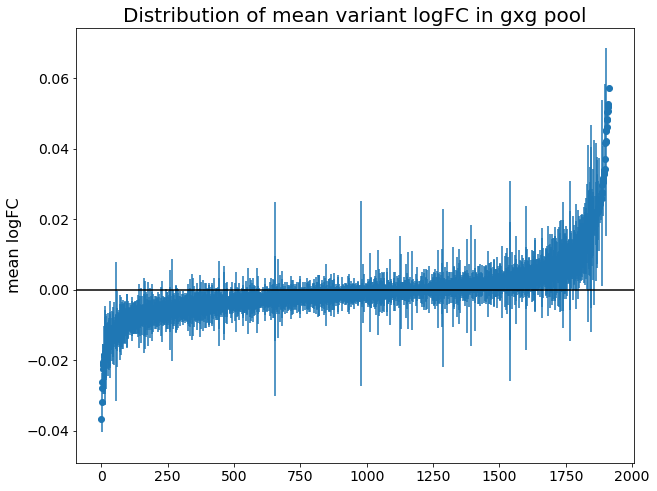

In [7]:
var_summary = deseq_results_df.groupby('var_id')['log2FoldChange'].agg(['mean','sem'])

# plot
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(np.arange(len(var_summary)), 'mean', data=var_summary.sort_values('mean'))
ax.errorbar(np.arange(len(var_summary)), 'mean', data=var_summary.sort_values('mean'), yerr='sem', marker='', linestyle='')
ax.axhline(0, color='k')
ax.set_ylabel('mean logFC', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of mean variant logFC in gxg pool', fontsize=20)
plt.show()

### (optional) do t-test on each variant to identify significant fitness effects
The unweighted t-test gives a general idea for how many significant fitness effects to expect from the data. Note that this does not account for heteroscedasticity and should only be used as rough guide to check the WLS output.

Statsmodels' implementation of t-test also gives you the option to implement frequency weights. This should be comparable to what you will find from weighted least squares regression

In [8]:
test_df = deseq_results_df.query('~barcode_id.isin(@neutral_barcodes_df.index)')
neutral_df = deseq_results_df.query('barcode_id.isin(@neutral_barcodes_df.index)')

# run unweighted t-test for each variant, comparing against neutral barcode distribution
ttest_res = test_df.groupby('var_id').apply(lambda x: ttest_ind(x['log2FoldChange'], neutral_df['log2FoldChange']))
ttest_res = pd.DataFrame.from_records(ttest_res, index= ttest_res.index, columns=['t', 'pvalue', 'df'])
ttest_res['padj'] = multipletests(ttest_res['pvalue'], alpha=0.05, method='fdr_bh')[1]

# add t-test results to var_summary
var_summary = var_summary.merge(ttest_res, how='inner', left_index=True, right_index=True).sort_values('padj')
display(var_summary)

,mean,sem,t,pvalue,df,padj
var_id,,,,,,
GXG_21902,-0.020569,0.002149,-7.732401,2.754998e-14,923.0,5.069197e-11
GXG_31785,0.022449,0.008489,6.812409,1.733676e-11,919.0,7.974912e-09
GXG_38168,0.041883,0.026761,6.826203,1.587272e-11,914.0,7.974912e-09
GXG_13868,0.041726,0.016584,6.844180,1.408775e-11,914.0,7.974912e-09
GXG_38667,0.057177,NaN,6.644635,5.218955e-11,913.0,1.920576e-08
...,...,...,...,...,...,...
GXG_13078,-0.000310,0.010952,0.002064,9.983540e-01,915.0,9.993675e-01
GXG_41453,-0.000328,0.007641,-0.001558,9.987572e-01,915.0,9.993675e-01
GXG_32808,-0.000316,0.003850,0.001474,9.988244e-01,924.0,9.993675e-01


In [9]:
# run weighted t-test 
w_ttest_res = test_df.groupby('var_id').apply(lambda x: ttest_ind(x['log2FoldChange'].values, neutral_df['log2FoldChange'].values, 
                                                                  weights=( (1/(x['lfcSE']**2) / (1/( pd.concat([x, neutral_df])['lfcSE']**2)).mean()).values, 
                                                                            (1/(neutral_df['lfcSE']**2) / (1/( pd.concat([x, neutral_df])['lfcSE']**2)).mean()).values ) ))
w_ttest_res = pd.DataFrame.from_records(w_ttest_res, index= ttest_res.index, columns=['w_t', 'w_pvalue', 'w_df'])
# adjust dtype due to weird array formatting
w_ttest_res['w_t'] = w_ttest_res['w_t'].astype(np.float64)
w_ttest_res['w_pvalue'] = w_ttest_res['w_pvalue'].astype(np.float64)
w_ttest_res['w_df'] = w_ttest_res['w_df'].astype(np.float64)
w_ttest_res['w_padj'] = multipletests(w_ttest_res['w_pvalue'], alpha=0.05, method='fdr_bh')[1]

# add weighted t-test results to var_summary
var_summary = var_summary.merge(w_ttest_res, how='inner', left_index=True, right_index=True)
display(var_summary)

,mean,sem,t,pvalue,df,padj,w_t,w_pvalue,w_df,w_padj
var_id,,,,,,,,,,
GXG_21902,-0.020569,0.002149,-7.732401,2.754998e-14,923.0,5.069197e-11,-5.396438,8.644197e-08,923.0,0.000040
GXG_31785,0.022449,0.008489,6.812409,1.733676e-11,919.0,7.974912e-09,2.320568,2.052832e-02,919.0,0.288337
GXG_38168,0.041883,0.026761,6.826203,1.587272e-11,914.0,7.974912e-09,2.454416,1.429688e-02,914.0,0.262828
GXG_13868,0.041726,0.016584,6.844180,1.408775e-11,914.0,7.974912e-09,2.451135,1.442697e-02,914.0,0.262828
GXG_38667,0.057177,NaN,6.644635,5.218955e-11,913.0,1.920576e-08,2.628159,8.728962e-03,913.0,0.226215
...,...,...,...,...,...,...,...,...,...,...
GXG_13078,-0.000310,0.010952,0.002064,9.983540e-01,915.0,9.993675e-01,-0.178486,8.583805e-01,915.0,0.973961
GXG_41453,-0.000328,0.007641,-0.001558,9.987572e-01,915.0,9.993675e-01,0.587335,5.571237e-01,915.0,0.871889
GXG_32808,-0.000316,0.003850,0.001474,9.988244e-01,924.0,9.993675e-01,0.600700,5.481871e-01,924.0,0.867583


### (optional) visualize neutral barcode distribution
This enables you to check the extent of heteroscedasticity in logFC values across read depths, as well as potential outliers  that may interfere with WLS

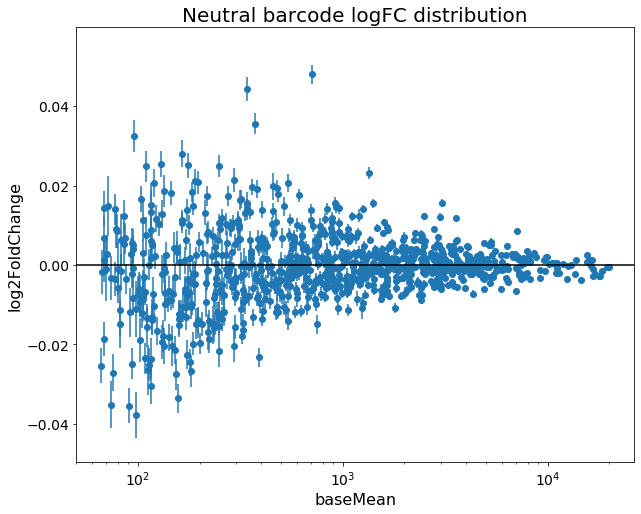

In [10]:
viz = deseq_results_df.query('barcode_id.isin(@neutral_barcodes_df.index)')

# plot
x = 'baseMean'
y = 'log2FoldChange'
y_error = 'lfcSE'

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x, y, data=viz)
ax.errorbar(x, y, data=viz, yerr=y_error, marker='', linestyle='')    
plt.axhline(0, color='k')

ax.set_xlabel(x, fontsize=16)
ax.set_ylabel(y, fontsize=16)
ax.set_title('Neutral barcode logFC distribution', fontsize=20)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

## Fit DESeq2 results into weighted least squares regression

In [11]:
# prepare input data
d = deseq_results_df.copy()
d.loc[d['barcode_id'].isin(neutral_barcodes_df.index), 'var_id'] = '.NEUTRAL' # sets neutral barcodes as reference
# d['log_count'] = np.log(d['baseMean'])

formula = 'log2FoldChange ~ C(var_id)' #
# formula = 'log2FoldChange ~ log_count + C(var_id)' # adjusts for skew in mean logFC due to low coverage
# formula = 'log2FoldChange ~ C(var_id) + C(cond) + C(var_id):C(cond)' # includes interaction term with condition of interest

w = 1/d['lfcSE']**2 

wls_res = wls(formula, data=d, weights=w).fit()
wls_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         log2FoldChange   R-squared:                       0.157
Model:                            WLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     1.818
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           1.15e-78
Time:                        17:28:42   Log-Likelihood:                 67638.
No. Observations:               19844   AIC:                        -1.316e+05
Df Residuals:                   18003   BIC:                        -1.171e+05
Df Model:                        1840                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0002      0.000      1.582      0.114   -4.98e-05       0.000
C(var_id)[T.GXG_00329]    -0.0011      0.001     -1.140      0.254      -0.003       0.001
C(var_id)[T.GXG_00332]    -0.0028      0.004     -0.680      0.496      -0.011       0.005
C(var_id)[T.GXG_00346]     0.0061      0.005      1.178      0.239      -0.004       0.016
C(var_id)[T.GXG_00347]     0.0026      0.003      0.824      0.410      -0.004       0.009
C(var_id)[T.GXG_00366]     0.0002      0.001      0.242      0.809      -0.002       0.002
C(var_id)[T.GXG_00374]    -0.0008      0.002     -0.531      0.596      -0.004       0.002
C(var_id)[T.GXG_00384]    -0.0035      0.003     -1.009      0.313      -0.010       0.003
C(var_id)[T.GXG_00385]     0.0010      0.001      0.678      0.498      -0.002       0.004
C(var_id)[T.GXG_00387]    -0.0015      0.002     -0.766      0.444      -0.005       0.002
C(var_id)[T.GXG_00388]    -0.0036      0.007     -0.504      0.614      -0.018       0.010
C(var_id)[T.GXG_00398]    -0.0113      0.006     -1.769      0.077      -0.024       0.001
C(var_id)[T.GXG_00422]    -0.0029      0.003     -0.866      0.386      -0.010       0.004
C(var_id)[T.GXG_00436]     0.0112      0.006      1.878      0.060      -0.000       0.023
C(var_id)[T.GXG_00437]    -0.0031      0.003     -0.999      0.318      -0.009       0.003
C(var_id)[T.GXG_00439]    -0.0009      0.003     -0.283      0.777      -0.007       0.006
C(var_id)[T.GXG_00440]    -0.0046      0.003     -1.652      0.099      -0.010       0.001
C(var_id)[T.GXG_00441]     0.0030      0.004      0.742      0.458      -0.005       0.011
C(var_id)[T.GXG_00442]    -0.0009      0.007     -0.123      0.902      -0.015       0.013
C(var_id)[T.GXG_00445]    -0.0031      0.002     -1.950      0.051      -0.006    1.57e-05
C(var_id)[T.GXG_00447]    -0.0023      0.001     -3.157      0.002      -0.004      -0.001
C(var_id)[T.GXG_00452]    -0.0016      0.001     -2.400      0.016      -0.003      -0.000
C(var_id)[T.GXG_00458]    -0.0023      0.001     -2.939      0.003      -0.004      -0.001
C(var_id)[T.GXG_00462]    -0.0017      0.001     -1.166      0.244      -0.004       0.001
C(var_id)[T.GXG_00475]    -0.0024      0.002     -1.141      0.254      -0.006       0.002
C(var_id)[T.GXG_00476]    -0.0003      0.001     -0.246      0.806      -0.003       0.002
C(var_id)[T.GXG_00480]     0.0006      0.002      0.375      0.708      -0.002       0.004
C(var_id)[T.GXG_00483]    -0.0049      0.001     -3.304      0.001      -0.008      -0.002
C(var_id)[T.GXG_00490]    -0.0017      0.001     -1.610      0.108      -0.004       0.000
C(var_id)[T.GXG_00492]    -0.0017      0.001     -1.169      0.243      -0.005       0.001
C(var_id)[T.GXG_00493]    -0.0007      0.002     -0.373      0.709      -0.004  

### (optional) check residuals to confirm heteroscedasticity is weighted appropriately

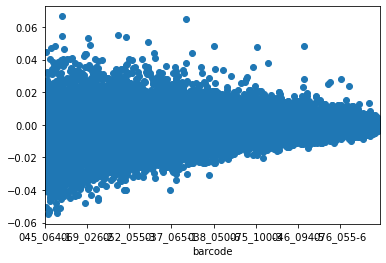

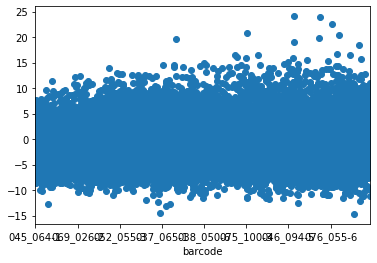

In [12]:
wls_res.resid[deseq_results_df.sort_values('baseMean').index].plot(marker='o', linestyle='')
plt.show()
wls_res.wresid[deseq_results_df.sort_values('baseMean').index].plot(marker='o', linestyle='')
plt.show()

## Calculate variant fitness from WLS model
Use calc_var_fitness as a wrapper for extracting the fitness values from WLS model. It can also calculate fitness in non-reference conditions as well, by supplying the appropriate terms in the "conditions" variable.

These functions were tested under the simplest WLS implementations (i.e. one interaction term between fitness and condition), and are not guaranteed to work for more complex fits with multiple interaction terms.

In [13]:
def calc_var_fitness(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks if the variant fitness effect 
    is significantly different from neutral in each condition (i.e. genotype/environment)
    '''
    # prep input
    conditions = sorted(conditions)
    test_names = []
    
    # build hypotheses
    covariates = lm.model.exog_names
    v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
    v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
    hyp = []
    for cond in conditions:
        # test if variant fitness effect is significantly different from zero
        test_names.append('{0},{1}'.format(v, cond))
        v_cond_cov = [c for c in v_cond_interactions if cond in c]
        # no interaction term if reference condition, else add interaction
        if len(v_cond_cov)==0: 
            hyp.append('{}=0'.format(v_cov))
        else:
            hyp.append('{}+{}=0'.format(v_cov, v_cond_cov[0])) # assumes each non-reference condition has only 1 term to add to calc fitness
    
    hyp = ','.join(hyp)
    
    # apply ttest and return result
    return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)

def calc_cond_interactions(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks between all conditions for significant interactions
    '''
    # prep input
    conditions = sorted(conditions)
    
    # build hypotheses
    covariates = lm.model.exog_names
    v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
    v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
    hyp = []
    test_names = []
    
    for i in range(len(conditions)-1):
        cond1 = conditions[i]
        v_cond1_cov = [c for c in v_cond_interactions if cond1 in c]
        if len(v_cond1_cov) == 0:
            v_cond1_cov = 0
        else:
            v_cond1_cov = v_cond1_cov[0]
        for j in range(i+1, len(conditions)):
            cond2 = conditions[j]
            v_cond2_cov = [c for c in v_cond_interactions if cond2 in c]
            if len(v_cond2_cov) == 0:
                v_cond2_cov = 0
            else:
                v_cond2_cov = v_cond2_cov[0]

            # add hypothesis test
            hyp.append('{0}={1}'.format(v_cond1_cov, v_cond2_cov))
            # add test name
            test_names.append('{0}: {1}-{2}'.format(v, cond1, cond2))

    hyp = ','.join(hyp)

    # apply ttest and return result
    return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)


In [14]:
var_list = sorted(deseq_results_df.query('~barcode_id.isin(@neutral_barcodes_df.index)').var_id.unique())
cond_list = ['BY']

var_fitness_df = pd.concat([calc_var_fitness(var, wls_res, cond_list) for var in var_list], join='inner', axis=0)

# adjust formatting
var_fitness_df.index = pd.MultiIndex.from_tuples(var_fitness_df.index.str.split(',').tolist(), names=['var_id', 'cond'])
var_fitness_df = var_fitness_df.reset_index()
# calc padj
var_fitness_df = var_fitness_df.rename(columns={'P>|t|': 'pval'})
var_fitness_df['padj'] = multipletests(var_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(var_fitness_df.sort_values('padj'))

# write to file
var_fitness_df.to_csv(var_fitness_file, sep='\t', header=True)

# TODO: speed up calc_var_fitness implementation???
# with mp.Pool(len(os.sched_getaffinity(0))) as pool:
#     var_fitness_df = pool.starmap(calc_var_fitness, [(v, wls_res, cond_list) for v in var_list])
#     var_fitness_df = pd.concat(var_fitness_df, join='inner', axis=0)
# #     manager = mp.Manager()
# #     shared_args = manager.list([(v, wls_res, cond_list) for v in var_list])
# #     var_fitness_df = pool.starmap(calc_var_fitness, [(v, wls_res, cond_list) for v in var_list])
# #     var_fitness_df = pd.concat(var_fitness_df, join='inner', axis=0)

,var_id,cond,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
947,GXG_26358,BY,6.108906e-03,0.000899,6.797619,1.096966e-11,0.004347,0.007870,2.018418e-08
946,GXG_26357,BY,4.862097e-03,0.000745,6.525223,6.971023e-11,0.003402,0.006323,6.413341e-08
1026,GXG_29813,BY,-3.255077e-03,0.000554,-5.874945,4.304365e-09,-0.004341,-0.002169,2.640011e-06
803,GXG_21902,BY,-1.846701e-02,0.003224,-5.727787,1.033724e-08,-0.024787,-0.012147,4.755131e-06
1768,GXG_49140,BY,-2.117575e-03,0.000432,-4.896772,9.826822e-07,-0.002965,-0.001270,3.616271e-04
...,...,...,...,...,...,...,...,...,...
82,GXG_01586,BY,1.943017e-05,0.004810,0.004040,9.967768e-01,-0.009408,0.009447,9.986152e-01
594,GXG_16577,BY,6.056381e-06,0.001604,0.003776,9.969871e-01,-0.003138,0.003150,9.986152e-01
1794,GXG_49805,BY,3.423820e-06,0.002117,0.001617,9.987096e-01,-0.004146,0.004153,9.992526e-01
896,GXG_25311,BY,3.244914e-06,0.001850,0.001754,9.986008e-01,-0.003624,0.003630,9.992526e-01


In [15]:
# TODO: add code for calculating condition interactions

### (optional) load ladder oligo annotations and ladder pilot deseq results, add to annotations table
The oligo design file does not include the 43 ladder oligos designed for CRISPEY3 pilot, so add it from separate file

In [ ]:
# ladder oligos annotations
ladder_annotations_file = "/home/users/rang/crispey3/ladder_pilot_feb2021/ladder_oligos_annotated.txt"
# ladder pilot deseq results
ladder_pilot_deseq_file = "/home/users/rang/crispey3/ladder_pilot_feb2021/deseq/ladder_pilot_deseq_results.txt"

In [ ]:
# load ladder pilot annotations
ladder_annotations_df = pd.read_csv(ladder_annotations_file, sep='\t', header=0, index_col=0)
ladder_annotations_df['oligo_id'] = ['tech_{}_hdr'.format(orf) for orf in ladder_annotations_df["ORF"]]
ladder_annotations_df['barcode_id'] = ['Ladder_{:0>3}'.format(int(x.split("_")[-1])+1) for x in ladder_annotations_df['Name']]

# load ladder pilot deseq data and append to ladder annotations
ladder_pilot_deseq_df = pd.read_csv(ladder_pilot_deseq_file, sep=',', header=0, index_col=0)
ladder_annotations_df = ladder_annotations_df.merge(ladder_pilot_deseq_df, how='left', left_on='PBC', right_index=True)
ladder_annotations_df = ladder_annotations_df[['barcode_id', 'oligo_id', 'breslow_growth_rate', 'log2FoldChange']]
ladder_annotations_df = ladder_annotations_df.rename(columns={'log2FoldChange':'pilot_logFC'})

# combine information to get complete ladder annotations df with breslow and pilot fitness data
ladder_annotations_df = ladder_annotations_df.merge(annotations_df, on='oligo_id', how='left').drop_duplicates().set_index('barcode_id')
# fill info for barcode "Ladder_40"
ladder_annotations_df.loc['Ladder_040', "var_id"] = "hdr_43"
ladder_annotations_df.loc['Ladder_040', "guide_id"] = "technical_999"
display(ladder_annotations_df)

# add to annotations table
annotations_df = pd.concat([annotations_df, ladder_annotations_df[annotations_df.columns]])
display(annotations_df)

### (optional) calculate normalized counts
useful for visualizing individual barcodes across time points

In [ ]:
counts_norm_df = counts_df.copy()
counts_norm_df = counts_norm_df[counts_norm_df.sum(axis=1)>=1000] # same read filter as DESeq2
counts_norm_df = counts_norm_df/counts_norm_df.sum(axis=0) * 1e6  #cpm
counts_norm_df = np.log2(counts_norm_df+1e-6) #log2(cpm), with 1 pseudocount
display(counts_norm_df)


### (optional) check a variant logFC distribution against neutral barcodes

In [ ]:
var = 'GXG_00384'

# plot
x = 'baseMean'
y = 'log2FoldChange'
y_error = 'lfcSE'

fig, ax = plt.subplots(figsize=(10,8))
# neutrals
ax.errorbar(x, y, data=deseq_results_df.query('barcode_id.isin(@neutral_barcodes_df.index)'), yerr=y_error, label='neutral', marker='o', linestyle='')
# variant, split by oligo
for b, df in deseq_results_df.query('var_id==@var').groupby('barcode_id'):
    ax.errorbar(x, y, data=df, yerr=y_error, label="{}, barcode {}".format(var, b), marker='o', linestyle='')
plt.axhline(0, color='k')

ax.set_xlabel('avg reads per sample', fontsize=16)
ax.set_ylabel('logFC', fontsize=16)
ax.set_title('{} vs neutral logFC'.format(var), fontsize=20)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()
plt.show()

In [ ]:
# def test_var_fitness(v, lm, genotypes, alpha=0.05):
#     '''
#     accepts variant name and fitted model, checks if the variant 
#     fitness effect is significantly different from neutral in each genotype
#     '''
#     # prep input
#     genotypes = sorted(genotypes)
#     test_names = []
    
#     # build hypotheses
#     covariates = lm.model.exog_names
#     v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
#     v_g_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-genotype interaction terms
#     hyp = []
#     for g in genotypes:
#         # test if variant fitness effect is significantly different from zero
#         test_names.append('{0},{1}'.format(v, g))
#         v_g_cov = [c for c in v_g_interactions if g in c]
#         # no interaction term if reference genotype, else add interaction
#         if len(v_g_cov)==0: 
#             hyp.append('{}=0'.format(v_cov))
#         else:
#             hyp.append('{}+{}=0'.format(v_cov, v_g_cov[0]))
    
#     hyp = ','.join(hyp)
    
#     # apply ttest and return result
#     return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)

# def test_gxg(v, lm, genotypes, alpha=0.05):
#     '''
#     accepts variant name and fitted model, checks between all genotypes for GxG interactions
#     '''
#     # prep input
#     genotypes = sorted(genotypes)
    
#     # build hypotheses
#     covariates = lm.model.exog_names
#     v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
#     v_g_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-genotype interaction terms
#     hyp = []
#     test_names = []
    
#     for i in range(len(genotypes)-1):
#         g1 = genotypes[i]
#         v_g1_cov = [c for c in v_g_interactions if g1 in c]
#         if len(v_g1_cov) == 0:
#             v_g1_cov = 0
#         else:
#             v_g1_cov = v_g1_cov[0]
#         for j in range(i+1, len(genotypes)):
#             g2 = genotypes[j]
#             v_g2_cov = [c for c in v_g_interactions if g2 in c]
#             if len(v_g2_cov) == 0:
#                 v_g2_cov = 0
#             else:
#                 v_g2_cov = v_g2_cov[0]

#             # add hypothesis test
#             hyp.append('{0}={1}'.format(v_g1_cov, v_g2_cov))
#             # add test name
#             test_names.append('{0}: {1}-{2}'.format(v, g1, g2))

#     hyp = ','.join(hyp)

#     # apply ttest and return result
#     return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)
